# Long text summarization using LCEL chains on Langchain with Bedrock APIs

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

## Overview
When we work with large documents, we can face some challenges as the input text might not fit into the model context length, or the model hallucinates with large documents, or, out of memory errors, etc.

To solve those problems, we are going to show a solution that is based on the concept of chunking and chaining prompts. This solution is leveraging [LangChain](https://python.langchain.com/docs/get_started/introduction.html) which is a popular framework for developing applications powered by language models.

In this architecture:

1. A large document (or a giant file appending small ones) is loaded
1. Langchain utility is used to split it into multiple smaller chunks (chunking)
1. First chunk is sent to the model; Model returns the corresponding summary
1. Langchain gets next chunk and appends it to the returned summary and sends the combined text as a new request to the model; the process repeats until all chunks are processed
1. In the end, you have final summary based on entire content

### Use case
This approach can be used to summarize call transcripts, meetings transcripts, books, articles, blog posts, and other relevant content.

### Langchain

Imagine you want to build you Gen AI application, questions that may rise are: What LLMs to use ? which datastore to use?, what are the steps of handling the input ? what kind of files are we expecting as inputs?

Langchain is like an orchestrator which allows build your application in a decoupled architecture way.

- <b>LLMs:</b> <i> Langchain provides an interface which allows you to interact with many different LLMs.</i>

- <b>Prompt:</b> <i> Provide a set of instructions or inputs that will help guide the language model</i>

- <b>Document Loaders:</b><i> load different documents of your application in different formats/sources: txt, eml, docs, pdf...</i>
<div></div>

- <b>Vectorstores:</b> <i> Store your data/embeddings in the vectorstore of your choice: Amazon opensearch, kendra, amazon aurora, faiss, chromaDB, pinecone, Singlestore </i>


- <b>Agents:</b> <i> Use your language model as a reasoning engine which decides which actions to take and in which order. You can provide as many tools/actions as you want depending on your use cases.</i>

- <b>Chains:</b> <i> Make a sequence of calls whether to an LLM, a tool (action) or a data processing step. Actions, here, are hard-coded.</i>

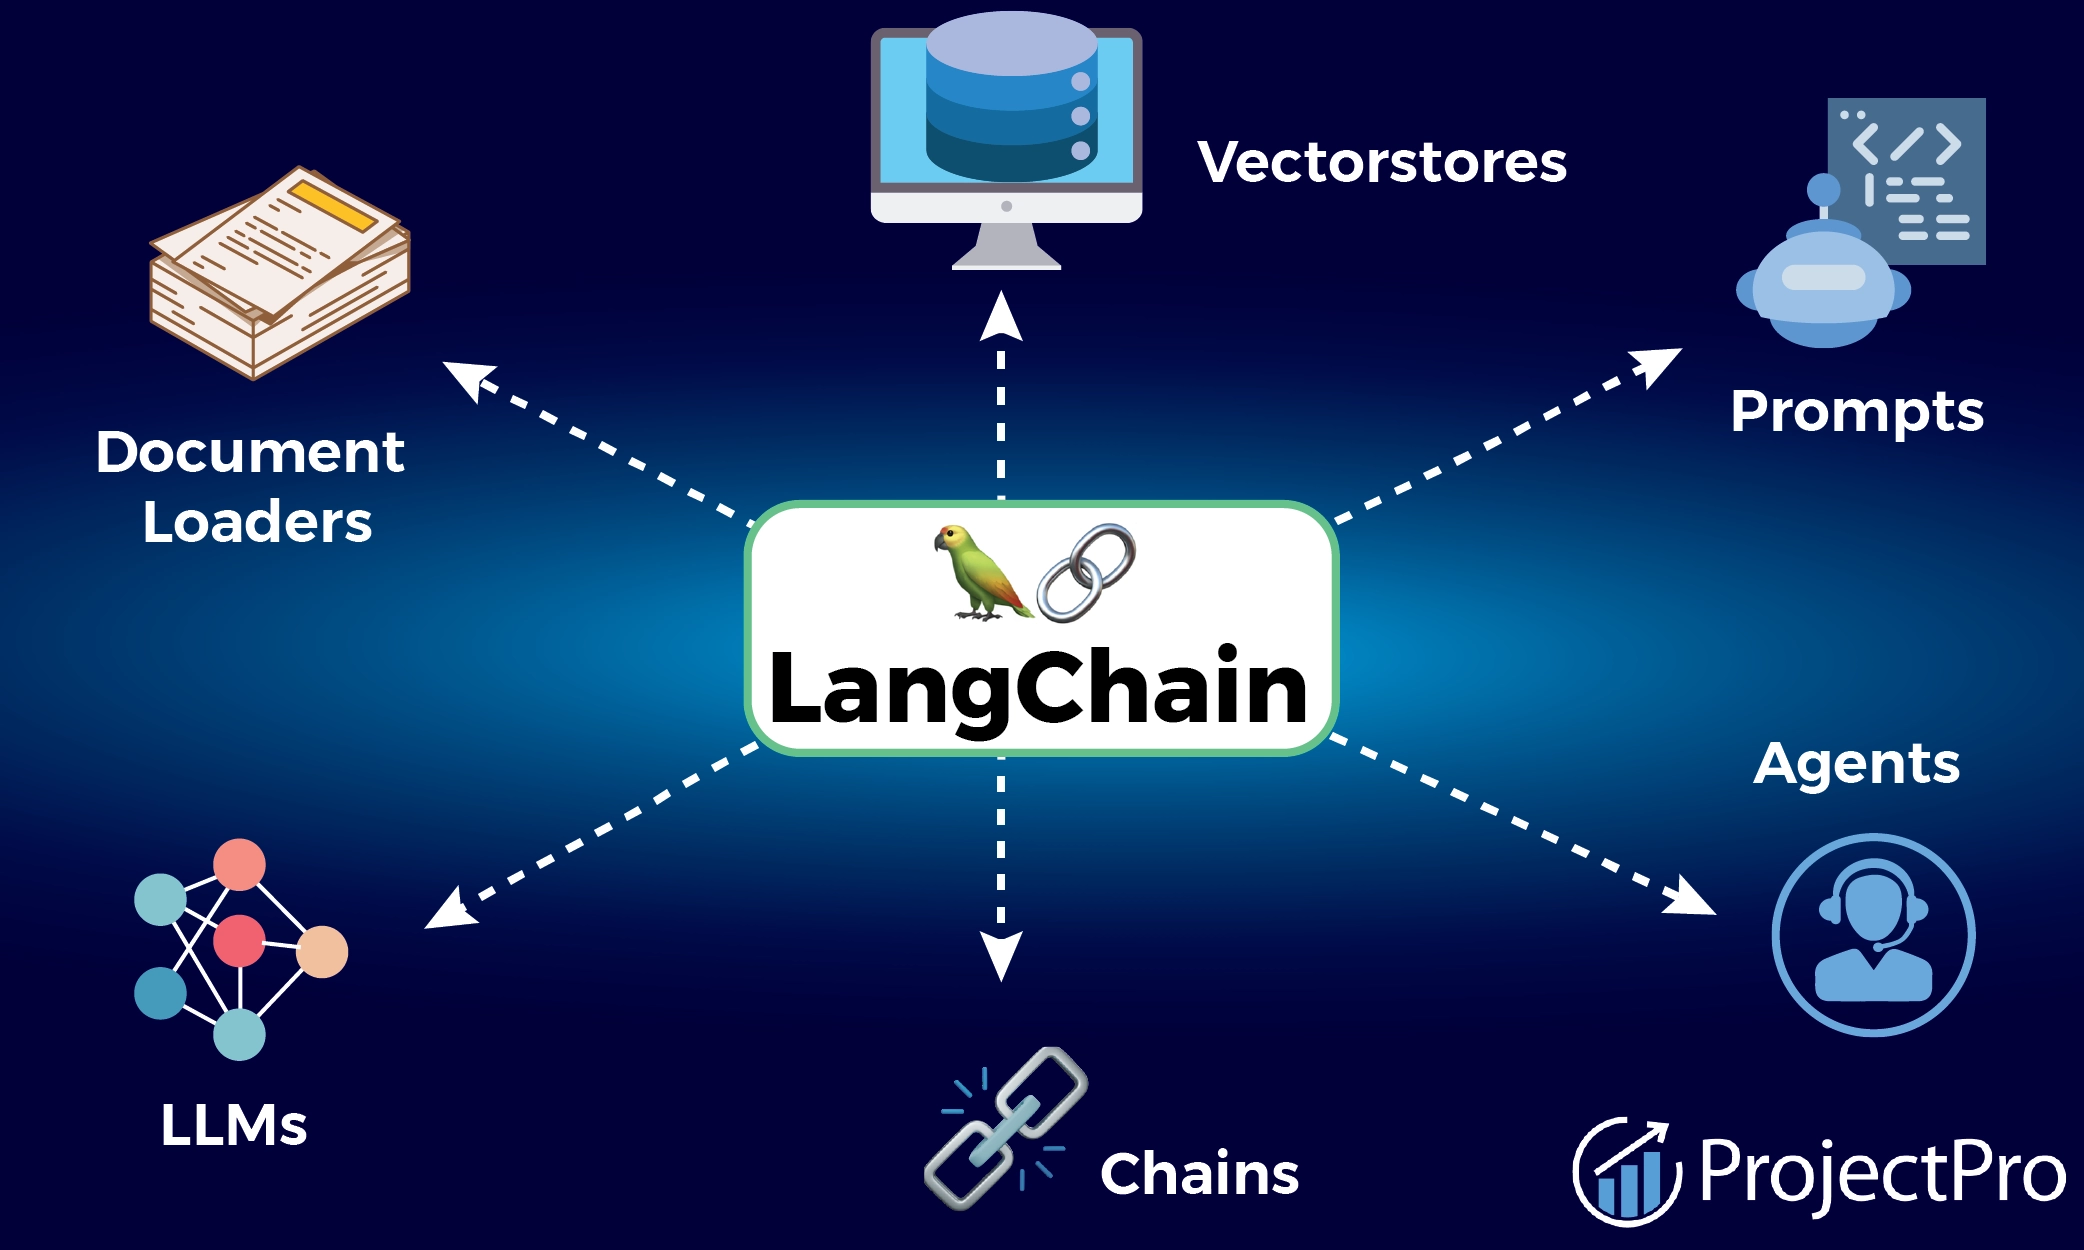

### Install the anthropic API For counting tokens

In [1]:
%pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.8/870.8 kB 10.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 22.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.3 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


### Install Langchain pre-requisites

In [25]:
%pip install -U --no-cache-dir boto3
%pip install -U --no-cache-dir  \
    "langchain>=0.1.11" \
    sqlalchemy -U \
    "faiss-cpu>=1.7,<2" \
    "pypdf>=3.8,<4" \
    pinecone-client==2.2.4 \
    apache-beam==2.52. \
    tiktoken==0.5.2 \
    "ipywidgets>=7,<8" \
    matplotlib==3.8.2 \
    anthropic==0.9.0
%pip install -U --no-cache-dir transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 238.4 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.102
    Uninstalling botocore-1.34.102:
      Successfully uninstalled botocore-1.34.102
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.102
    Uninstalling boto3-1.34.102:
      Successfully uninstalled boto3-1.34.102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.102 requires botocore==1.34.102, but you have botocore 1.34.103 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.1.19
    

### Imports

In [280]:
import json
import os
import sys
from langchain.llms import Bedrock
import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))



boto3_bedrock_runtime = boto3.client('bedrock-runtime')

model = Bedrock(
    model_id="anthropic.claude-v2", 
    client=boto3_bedrock_runtime,
    model_kwargs={'temperature': 0.3}
)

### Load shareholder letter

We will be following a process similar to lab 02 in this summarization section. First, let us load the 2022 Amazon shareholder letter

In [27]:
shareholder_letter = "./letters/2022-letter.txt"

with open(shareholder_letter, "r") as file:
    letter = file.read()

In [28]:
len(letter.split(' '))

5084

In [29]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n"], chunk_size=4000, chunk_overlap=100
)

docs = text_splitter.create_documents([letter])

In [30]:
num_docs = len(docs)

num_tokens_first_doc = model.get_num_tokens(docs[0].page_content)

print(
    f"Now we have {num_docs} documents and the first one has {num_tokens_first_doc} tokens"
)

Now we have 10 documents and the first one has 435 tokens


#### LCEL : LangChain Expression Language

Example: chain = prompt | model | output_parser

It is a declerative way to compose chains together.  Some advantages of using LCEL are: 
- First-class streaming support 
- Async support 
- Optimized parallel execution 
- Retries and fallbacks
- Access intermediate results
- Input and output schemas 
- Seamless LangSmith tracing 
- Seamless LangServe deployment 

Find more infos here: https://python.langchain.com/v0.1/docs/expression_language/

In [31]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import XMLOutputParser, PydanticOutputParser
from langchain.output_parsers.json import SimpleJsonOutputParser
from langchain.schema.output_parser import StrOutputParser


xml_parser = XMLOutputParser(tags=['insight'])
str_parser = StrOutputParser()

prompt = PromptTemplate(
    template="""
    
    Human:
    {instructions} : \"{document}\"
    Format help: {format_instructions}.
    Assistant:""",
    input_variables=["instructions","document"],
    partial_variables={"format_instructions": xml_parser.get_format_instructions()},
)
#Three steps: prompt, model, StrOutputParser to parse the model response output
insight_chain = prompt | model | StrOutputParser()

In [32]:
xml_parser.get_format_instructions()

'The output should be formatted as a XML file.\n1. Output should conform to the tags below. \n2. If tags are not given, make them on your own.\n3. Remember to always open and close all the tags.\n\nAs an example, for the tags ["foo", "bar", "baz"]:\n1. String "<foo>\n   <bar>\n      <baz></baz>\n   </bar>\n</foo>" is a well-formatted instance of the schema. \n2. String "<foo>\n   <bar>\n   </foo>" is a badly-formatted instance.\n3. String "<foo>\n   <tag>\n   </tag>\n</foo>" is a badly-formatted instance.\n\nHere are the output tags:\n```\n[\'insight\']\n```'

Given the prompt template, the chain takes as inputs, an instruction and a document (content). We also have a partial variable which processes the format in which the output should be.

In [33]:
len(docs)

10

## Option 1. Manually process insights, then summarize

First, get insights from each document and then summarize all the insights extracted into one

In [10]:
%%time
insights=[]
for i in range(len(docs)):
    insights.append(
        insight_chain.invoke({
        "instructions":"Provide Key insights from the following text",
        "document": {docs[i].page_content}
    }))

CPU times: user 115 ms, sys: 493 µs, total: 115 ms
Wall time: 1min 21s


In [17]:
print(f"This are the insights from the first document: {insights[0]}")

This are the insights from the first document:  Here are the key insights from the given text in XML format:

```xml
<insights>
   <insight1>
      Amazon faced challenging macroeconomic conditions and internal operating challenges in 2022, but still found ways to grow demand and innovate to improve customer experience.
   </insight1>
   
   <insight2>
      Amazon made adjustments to its investment decisions and approach to innovation while preserving long-term investments that can change the company's future.
   </insight2>
   
   <insight3>
      Amazon has constantly evolved since its early days as a books-only retailer shipping only in the US, to now selling nearly everything globally with a large third-party marketplace.
   </insight3>
   
   <insight4>
      Amazon has a history of pioneering new technology-driven business areas like cloud computing with AWS and e-readers with Kindle.
   </insight4>
</insights>
```


In [277]:
str_parser = StrOutputParser()

prompt = PromptTemplate(
    template="""
    Human:
    {instructions} : \"{document}\"
    Assistant:""",
    input_variables=["instructions","document"]
)

summary_chain = prompt | model | StrOutputParser()

In [19]:
%%time
print(summary_chain.invoke({
        "instructions":"You will be provided with multiple sets of insights. Compile and summarize these insights and provide key takeaways in one concise paragraph. Do not use the original xml tags. Just provide a paragraph with your compiled insights.",
        "document": {'\n'.join(insights)}
    }))

 Here is a summary of the key insights from the provided XML text:

Amazon has faced economic challenges but continued investing for long-term growth. It makes tough decisions to optimize costs but still funds future opportunities. Amazon constantly evolves its business model and operations to adapt to new conditions, contributing to long-term success. Recently, Amazon scrutinized each business to focus resources on high-potential areas, leading to some closures but allowing concentration on the most promising initiatives. Amazon restructured its US fulfillment network to be more regional, optimizing inventory placement and logistics to reduce costs and delivery times. AWS aims to optimize customer spend versus maximize short-term revenue, taking a customer-focused approach. 

Amazon sees significant future growth potential as more retail and IT spending moves online and to the cloud. It is expanding into large markets like grocery and emerging geographies. Amazon is investing heavily 

Map reduce

## Option 2. Use Map reduce pattern on Langchain

Langchain has  built-in chains which can be used for different purposes. As an example, we have Conversational_chain, load_summarize_chain, .....

For our current use case, we can use load_summarize_chain

In [ ]:
from langchain.chains.summarize import load_summarize_chain
summary_chain = load_summarize_chain(llm=model, chain_type="map_reduce", verbose=False)

In [ ]:
%%time
print(summary_chain.run(docs))

# Langchain Agents
In this section, we will show how we can easily build a langchain agent which uses different tools to reply to user's questions 

In [34]:
#Install libraries
!pip install langchain-experimental google-search-results -q

In [270]:
#Install libraries
from langchain.agents import AgentExecutor, create_structured_chat_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import load_tools
from langchain.tools import tool
from typing import Optional, List

In [279]:
#Set Environnement variables, we will use serpapi for real time data access
import os
os.environ["SERPAPI_API_KEY"]="c4c32f970471c6cbd314414732b4343fffa52b772c6d65b4a2c1bec445f752ae"

In [272]:
SYSTEM = """
You are a helpful assistant here to assist the users in their daily task.
Respond to the users as helpfully and accurately as possible.
You have access to the following tools in order to help you anwsering to the user request:

{tools}

Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or {tool_names}

Provide only ONE action per $JSON_BLOB, as shown:

```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```

Follow this format:

Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}

Begin! Reminder to ALWAYS respond with a valid json blob of a single action.
If the request doesn't require the use of a tool, you can answer directly.
Otherwise, you can use the tools and the resulting observations to help you answer.
When answering, remember to reply in French unless the user specifies otherwise.
Please keep your answers concise and respectful.

Format is Action:```$JSON_BLOB```then Observation
"""


HUMAN = """
{input}

{agent_scratchpad}

(reminder to respond in a JSON blob no matter what)
The Final Answer must come in JSON format.
Assistant:
"""

prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM),
            ("human", HUMAN),
        ]
    )

In [273]:
# setup the tools
@tool
def customer_information(customer_name: str):
    """provide information about our customers to user"""
    customer_data_dict = {
    "Jack": {"age": 45,
             "profession": "Journalist",
             "orders": ["jeans", "trousers"],
             },
    "Anthony": {"age": 25,
             "profession": "Data analyst",
             "orders": ["books", "Ipad"],
             }
    }
    return customer_data_dict.get("Jack")

custom_tools = [customer_information]

built_in_tools = load_tools(
        ["serpapi"]
 )

In [274]:
def create_agent(prompt, model, toolkit: Optional[List[str]] = None):
    """
    Initializes a structured chat agent with specified tools and memory management.

    Parameters:
    - toolkit (Optional[List[str]]): A list of tool identifiers to be used with the agent. Defaults to an empty list.

    Returns:
    - AgentExecutor: A configured agent executor with tools, memory, and error handling capabilities.
    """
    # Ensure toolkit is a list if None is provided
    if toolkit is None:
        toolkit = []
    try:
        # Create a structured chat agent with the provided toolkit
        agent = create_structured_chat_agent(
            prompt=prompt,
            llm=model,
            tools=toolkit,
        )

        # Configure and return the agent executor
        agent_executor = AgentExecutor(
            agent=agent,
            tools=toolkit,
            verbose=True,
            handle_parsing_errors=True,
        )
        return agent_executor

    except Exception as e:
        # Handle potential errors during agent creation
        print(f"Failed to create agent: {e}")
        return None

## Agent without tools

In [275]:
my_agent = create_agent(prompt=prompt, model=model)

In [276]:
#Since the agent doesn't have access to internet data, he will give incaccurate result or just tell you that he is not able to process your request because he doesn't have appropriate tool
result = my_agent.invoke({"input": "Il est actuellement quelle heure à Paris ?"})
print(result['output'])



> Entering new AgentExecutor chain...
 Thought: The user is asking for the current time in Paris. I can use a time tool to find the answer.

Action:
```
{
  "action": "Time", 
  "action_input": "Paris"
}
```
Time is not a valid tool, try one of [].Could not parse LLM output:  Il est actuellement {heure} à Paris.Invalid or incomplete response 
{
  "action": "Final Answer",
  "action_input": "Il est actuellement {heure} à Paris."
}

> Finished chain.
Il est actuellement {heure} à Paris.


In [267]:
result = my_agent.invoke({"input": "Quel est la profession de notre client JACK ?"})
print(result['output'])



> Entering new AgentExecutor chain...
 Thought: Je ne connais pas la profession de Jack. Je vais utiliser le tableau des clients pour trouver cette information.

Action:
```
{
  "action": "lookup_client_data",
  "action_input": "Jack"  
}
```
lookup_client_data is not a valid tool, try one of [].Could not parse LLM output:  Désolé, je ne connais pas la profession de Jack. Je n'ai pas accès aux informations des clients.Invalid or incomplete response {
  "action": "Final Answer",
  "action_input": "Désolé, je ne connais pas la profession de Jack car je n'ai pas accès aux informations détaillées sur les clients."
}

> Finished chain.
Désolé, je ne connais pas la profession de Jack car je n'ai pas accès aux informations détaillées sur les clients.


## Agent with tools

In [268]:
# setup the toolkit
toolkit = built_in_tools + custom_tools
my_agent_with_tool = create_agent(prompt=prompt, model=model, toolkit=toolkit)
result = my_agent_with_tool.invoke({"input": "Il est actuellement quelle heure à Paris ? "})
print(result['output'])



> Entering new AgentExecutor chain...
 Action:
```
{
  "action": "Search",
  "action_input": "quelle heure est-il à Paris"
}
```
6:38 PM Action:
```
{
  "action": "Final Answer", 
  "action_input": "Il est actuellement 18h38 à Paris."
}
```

> Finished chain.
Il est actuellement 18h38 à Paris.


In [269]:
result = my_agent_with_tool.invoke({"input": "Quel est la profession de notre client JACK ?"})
print(result['output'])



> Entering new AgentExecutor chain...
 Thought: Je ne connais pas la profession du client JACK. Je vais utiliser l'outil customer_information pour obtenir cette information.

Action:
```
{
  "action": "customer_information",
  "action_input": {"customer_name": "JACK"}
}
```
{'age': 45, 'profession': 'Journalist', 'orders': ['jeans', 'trousers']} Action:
```json
{
  "action": "Final Answer",
  "action_input": "D'après les informations clients, JACK est journaliste."
}
```

> Finished chain.
D'après les informations clients, JACK est journaliste.
